In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,gc
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/MyDrive')

In [5]:
os.listdir('open_data_battle')

['.DS_Store', 'mpp', 'exam']

In [6]:
# данные

df = pd.read_csv('open_data_battle/mpp/data.csv')
PD = pd.read_csv('open_data_battle/mpp/model.csv')

In [7]:
PD

,incident,PD
0,14511110,0.022191
1,15018800,0.019972
2,14499737,0.043884
3,14953427,0.013412
4,14744453,0.033354
...,...,...
82612,20559842,NaN
82613,20380255,NaN
82614,20348581,NaN
82615,21118162,NaN


In [8]:
# выведем целевую переменную
df['target'] = np.abs(PD['PD'] - df['flg_90_12_add'])

In [9]:
# разобъем датасет на трейн и тест
df_test = df.iloc[81617:, :].drop(['target'], axis=1)
df_train = df.iloc[:81617, :]

In [10]:
# отделим целевую переменную
y = df_train['target']

In [11]:
# удалим признаки incident и flg_90_12_add

df_test.drop(['incident', 'flg_90_12_add'], axis=1, inplace=True)
df_train.drop(['incident', 'flg_90_12_add'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
df_train.shape, df_test.shape

((81617, 1909), (1000, 1908))

## Предобработка данных

Посмотрим на целевую переменную

Распределение целевой переменной не является нормальным, будем его логарифмировать, чтобы приблизить к нормальному

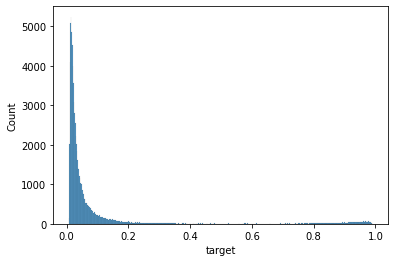

In [13]:
sns.histplot(y)
plt.show()

Посмотрим на данные

Названия всех признаков зашифрованы, а категориальные признаки закодированы

In [14]:
df_train

,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,Category_Feature_7,Category_Feature_8,Category_Feature_9,Category_Feature_10,Category_Feature_11,Category_Feature_12,Category_Feature_13,Category_Feature_14,Category_Feature_15,Category_Feature_16,Category_Feature_17,Category_Feature_18,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,...,Feature_1849,Feature_1850,Feature_1851,Feature_1852,Feature_1853,Feature_1854,Feature_1855,Feature_1856,Feature_1857,Feature_1858,Feature_1859,Feature_1860,Feature_1861,Feature_1862,Feature_1863,Feature_1864,Feature_1865,Feature_1866,Feature_1867,Feature_1868,Feature_1869,Feature_1870,Feature_1871,Feature_1872,Feature_1873,Feature_1874,Feature_1875,Feature_1876,Feature_1877,Feature_1878,Feature_1879,Feature_1880,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,target
0,2018-10,6.0,2,25,2.0,0.0,3,1,2.0,35000.0000,0.0,0.0,1.0,0.0,2.0,7.0,4.0,28.0,6.0,3.0,NaN,NaN,NaN,0.225000,0.175000,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.053696,5.053696,5.053696,5.053696,5.053696,5.053696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,20184,0.022191
1,2018-12,1.0,2,49,4.0,0.0,3,1,2.0,50000.0000,0.0,0.0,0.0,0.0,2.0,7.0,5.0,23.0,3.0,4.0,NaN,NaN,NaN,0.333333,0.166667,0,0,7,1,0,0,0,4,1,0,0,0,3,1,0,...,1.0,12969.251635,27353.234548,14383.982913,14383.982913,0.474140,0.901645,0.901645,1.901645,1.901645,1.0,0,0.526316,0.526316,0.600000,0.600000,0.526316,0.526316,0.043231,0.091177,0.047947,0.047947,0.043231,0.091177,0.047947,0.047947,0.129693,0.273532,0.14384,0.14384,0.259385,0.547065,0.287680,0.28768,0,1,1,1,20184,0.019972
2,2018-10,6.0,2,24,1.0,0.0,3,0,1.0,20000.0000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253165,0.253165,0,1,10,2,2,0,1,10,5,2,0,1,8,5,2,...,NaN,8406.411307,4853.739804,NaN,NaN,1.731945,NaN,NaN,NaN,NaN,NaN,0,1.128571,1.128571,0.790000,0.790000,0.087778,0.087778,0.106410,0.061440,NaN,NaN,0.106410,0.061440,NaN,NaN,0.420321,0.242687,NaN,NaN,0.420321,0.242687,NaN,NaN,0,1,0,1,20184,0.043884
3,2018-12,4.0,2,26,1.0,0.0,3,1,2.0,30000.0000,0.0,0.0,0.0,0.0,2.0,7.0,1.0,32.0,1.0,4.0,NaN,NaN,NaN,0.650000,0.150000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,20184,0.013412
4,2018-11,6.0,2,30,4.0,2.0,3,1,3.0,50000.0000,0.0,0.0,1.0,0.0,2.0,7.0,5.0,22.0,5.0,4.0,NaN,NaN,NaN,0.900000,0.250000,0,1,3,3,0,0,1,3,4,0,0,1,3,4,0,...,NaN,2293.148913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.883465,2.883465,10.473946,10.473946,0.188679,0.188679,0.011466,NaN,NaN,NaN,0.011466,NaN,NaN,NaN,0.012740,NaN,NaN,NaN,0.045863,NaN,NaN,NaN,0,1,0,1,20184,0.033354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81612,2020-02,1.0,2,56,2.0,0.0,3,0,4.0,66000.0000,0.0,1.0,0.0,1.0,2.0,7.0,5.0,4.0,1.0,1.0,4.200000,2.200000,0.080645,2.520000,1.320000,0,0,12,1,0,0,0,12,4,0,0,0,9,4,0,...,NaN,16327.213631,8368.091921,2351.158724,NaN,1.951127,6.944326,NaN,3.559135,NaN,NaN,0,0.386056,0.386056,0.386056,0.386056,0.386056,0.386056,0.326544,0.167362,0.047023,NaN,0.326544,0.167362,0.047023,NaN,0.129581,0.066413,0.01866,NaN,0.247382,0.126789,0.035624,NaN,0,0,1,1,20201,0.037867
81613,2020-02,4.0,2,29,2.0,1.0,5,0,2.0,0.0000,0.0,0.0,0.0,0.0,2.0,8.0,4.0,22.0,3.0,4.0,2.200000,0.000000,0.322581,0.330000,0.000000,0,0,9,3,1,0,0,6,2,0,0,0,4,2,0,...,NaN,4311.896859,2455.173754,NaN,NaN,1.7562

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81617 entries, 0 to 81616
Columns: 1909 entries, APPLICATION_MONTH to target
dtypes: float64(1837), int64(71), object(1)
memory usage: 1.2+ GB


В датасете все признаки в числовом формате, кроме 'APPLICATION_MONTH', разобьем его на два новых признака: year и month

In [16]:
df_train['APPLICATION_MONTH'].value_counts()

2019-06    6732
2019-07    6687
2019-04    6686
2019-11    5906
2019-03    5679
2019-12    5427
2019-08    5349
2019-10    4843
2019-09    4692
2019-05    4669
2020-02    4521
2020-01    3965
2020-03    3592
2019-02    3554
2018-11    2999
2018-12    2254
2019-01    2230
2018-10    1832
Name: APPLICATION_MONTH, dtype: int64

In [17]:
df_test['APPLICATION_MONTH'].value_counts()

2020-02    374
2020-01    328
2020-03    298
Name: APPLICATION_MONTH, dtype: int64

Видим, что наблюдения в тестовой выборке в более поздние даты, чем в трейне, поэтому будем использовать  кросс-валидацию, разбивая данные на фолды по месяцам

In [18]:
df_train['date'] = pd.to_datetime(df_train['APPLICATION_MONTH'], format='%Y-%m-%d')
df_test['date'] = pd.to_datetime(df_test['APPLICATION_MONTH'], format='%Y-%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
# признак year
df_train['year'] = df_train['date'].dt.year
df_test['year'] = df_test['date'].dt.year

# признак month
df_train['month'] = df_train['date'].dt.month
df_test['month'] = df_test['date'].dt.month

# удалим 'APPLICATION_MONTH'
df_train.drop('APPLICATION_MONTH', axis=1, inplace=True)
df_test.drop('APPLICATION_MONTH', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [20]:
# удалиим признак date
df_train.drop('date', axis=1, inplace=True)
df_test.drop('date', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Посмотрим на пропуски в датасете

In [21]:
print(f'В тренйне {round((df_train.isna().sum() > 1).mean(), 2) * 100}% признаков имеют пропуски')
print(f'В тесте {round((df_test.isna().sum() > 1).mean(), 3) * 100}% признаков имеют пропуски')

В тренйне 93.0% признаков имеют пропуски
В тесте 92.7% признаков имеют пропуски


In [22]:
train_nans = df_train.isna().mean().sort_values(ascending=False)
for num in [0.9, 0.75, 0.5]:
  print(f'В трейне {(train_nans > num).sum()} признак с пропусками более {num * 100}%')

В трейне 695 признак с пропусками более 90.0%
В трейне 1107 признак с пропусками более 75.0%
В трейне 1491 признак с пропусками более 50.0%


In [23]:
test_nans = df_test.isna().mean().sort_values(ascending=False)
for num in [0.9, 0.75, 0.5]:
  print(f'В трейне {(test_nans > num).sum()} признак с пропусками более {num * 100}%')

В трейне 657 признак с пропусками более 90.0%
В трейне 1037 признак с пропусками более 75.0%
В трейне 1397 признак с пропусками более 50.0%


Удалим все признаки, где пропусков больше 50%

In [24]:
# признаки на удаление
cols_to_del = train_nans[train_nans > 0.5].index.tolist()

In [25]:
# удаление признаков с пропусками более 50%
df_train.drop(cols_to_del, axis=1, inplace=True)
df_test.drop(cols_to_del, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
df_train.shape, df_test.shape

((81617, 419), (1000, 418))

После удаления признаков с пропусками более 50%, осталось 418 признаков

Найдем признаки с низкой информативностью: признаки где более 95% значений принадлежат одному значению

In [27]:
low_information_cols = []
for col in df_train.columns:
  val_cnt = df_train[col].value_counts(dropna=False)
  top_prct = (val_cnt / df_train.shape[0]).iloc[0]

  if top_prct > 0.95:
    low_information_cols.append(col)
    print(f'{col}: {top_prct}')
    print(val_cnt)

Category_Feature_9: 0.9739392528517343
0.0    79490
1.0     1843
NaN      284
Name: Category_Feature_9, dtype: int64
Feature_15: 0.9679723586997807
0     79003
1      2379
2       200
3        26
4         7
12        1
5         1
Name: Feature_15, dtype: int64
Feature_20: 0.9896100077189801
0     80769
1       819
2        23
3         5
10        1
Name: Feature_20, dtype: int64
Feature_21: 0.9623240256319149
0    78542
1     3008
2       63
3        4
Name: Feature_21, dtype: int64
Feature_24: 0.9718563534557751
0      79320
1       1328
2        281
3        163
4        101
6         60
5         59
7         44
8         37
10        32
9         31
11        26
15        17
12        15
13        15
14         8
16         7
26         6
21         5
17         5
18         5
19         5
20         5
23         4
28         4
30         4
32         3
37         2
85         2
25         2
51         2
41         2
43         2
68         2
45         1
58         1
118       

In [28]:
print(f'Признаков с низкой информативностью: {len(low_information_cols)}, удалим их.')

Признаков с низкой информативностью: 38, удалим их.


In [29]:
df_train.drop(low_information_cols, axis=1, inplace=True)
df_test.drop(low_information_cols, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
df_train.shape, df_test.shape

((81617, 381), (1000, 380))

Осталось 380 признаков

Посмотрим нет ли в данных дубликатов

In [31]:
print(f'В датасете {df_train.duplicated().sum()} дубликатов.')

В датасете 0 дубликатов.


Заполним пропуски константой -1

In [32]:
df_train = df_train.fillna(-1)
df_test = df_test.fillna(-1)
df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

## Обучение и прогноз

Мы обучим 12 моделей XGBRegressor, а затем усредним их прогноз.  Прогнозировать тестовую выборку будем с GroupKFold, с месяцами в виде фолдов. На каждом шаге итерации будем обучаться на всех месяцах, кроме одного, который будет валидационным.Также на каждом шаге будем прогнозировать всю тестовую выборку, а результаты затем усредним.

In [33]:
from sklearn.model_selection import GroupKFold

In [33]:
groups = df_train['month'].unique()
group_kfold = GroupKFold(n_splits=12)

In [34]:
groups

array([10, 12, 11,  1,  3,  2,  4,  6,  5,  8,  9,  7])

In [35]:
group_kfold.get_n_splits(df_train.drop('target', axis=1), y, groups)

12

In [36]:
# датафрейм, в котором будем хранить прогнозы с каждой итерации
pred_test = pd.DataFrame()
p = 1

for train_index, test_index in group_kfold.split(df_train.drop(['target'], axis=1), y, df_train['month']):
  print(f'Валидационный месяц: {df_train.iloc[test_index].month.iloc[0]}')
  print(f'Train: {len(train_index)} наблюдений, Val: {len(test_index)} наблюдений')
  # разбиваем выборку на трейн и валидацию, логарифмируя целевую переменную
  X_train, X_val = df_train.drop(['target'], axis=1).iloc[train_index], df_train.drop(['target'], axis=1).iloc[test_index]
  y_train, y_val = np.log(y.iloc[train_index]), np.log(y.iloc[test_index])
  # инициализация модели
  x = XGBRegressor(n_estimators=275, max_depth=4, missing=-1, tree_method='gpu_hist', verbosity=0)
  # обучение
  x.fit(X_train, y_train)
  # прогноз валидационной выборки
  pred_val = x.predict(X_val)
  # метрика
  mae = mean_absolute_error(np.exp(y_val), np.exp(pred_val))
  
  print(f'MAE: {mae}\n')
  # прогноз тестовой выборки
  pred = x.predict(df_test)
  # фиксируем проноз в датафрейм
  pred_test[f'pred_{p}'] = pred
  p+=1

Валидационный месяц: 3
Train: 72346 наблюдений, Val: 9271 наблюдений
MAE: 0.05606133540086771

Валидационный месяц: 11
Train: 72712 наблюдений, Val: 8905 наблюдений
MAE: 0.05189514469271444

Валидационный месяц: 2
Train: 73542 наблюдений, Val: 8075 наблюдений
MAE: 0.05294679262328859

Валидационный месяц: 12
Train: 73936 наблюдений, Val: 7681 наблюдений
MAE: 0.058423916158337155

Валидационный месяц: 6
Train: 74885 наблюдений, Val: 6732 наблюдений
MAE: 0.06245481998031366

Валидационный месяц: 7
Train: 74930 наблюдений, Val: 6687 наблюдений
MAE: 0.06675725358789099

Валидационный месяц: 4
Train: 74931 наблюдений, Val: 6686 наблюдений
MAE: 0.06272502725967476

Валидационный месяц: 10
Train: 74942 наблюдений, Val: 6675 наблюдений
MAE: 0.053981707736105194

Валидационный месяц: 1
Train: 75422 наблюдений, Val: 6195 наблюдений
MAE: 0.05683418758852951

Валидационный месяц: 8
Train: 76268 наблюдений, Val: 5349 наблюдений
MAE: 0.06029225400845925

Валидационный месяц: 9
Train: 76925 наблюдени

In [37]:
# усредним прогнозы моделей
sub_df = pd.DataFrame(np.exp(pred_test.mean(axis=1)))

In [38]:
# сохраним итоговый прогноз
sub_df.to_csv('odb_final_submission.csv', index=False, header=False)

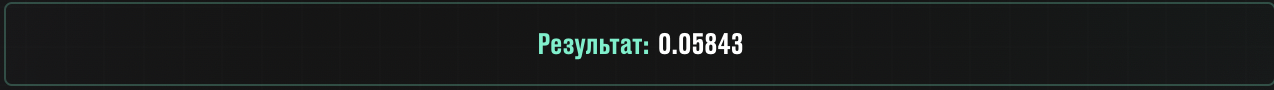